In [ ]:
"""
   대화 내역 요약 과정
   - 대화가 긴지 확인
   - 요약 생성
   - 대화 내용 지우기
"""

In [1]:
%%capture --no-stderr
#%pip install --quiet -U langgraph langchain_anthropic

In [2]:
from dotenv import load_dotenv
load_dotenv('../envls')

import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

In [ ]:
# LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [3]:
from typing import Literal

from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, RemoveMessage
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessagesState, StateGraph, START, END

memory = SqliteSaver.from_conn_string(":memory:")

# We will add a `summary` attribute (in addition to `messages` key, which MessagesState already has)
class State(MessagesState):
    summary: str

# We will use this model for both the conversation and the summarization
model = ChatAnthropic(model_name="claude-3-haiku-20240307")

# Define the logic to call the model
def call_model(state: State):
    # If a summary exists, we add this in as a system message
    summary = state.get('summary', '')
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state['messages']
    else:
        messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We now define the logic for determining whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    """Return the next node to execute."""
    messages = state["messages"]
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    # Otherwise we can just end
    return END


def summarize_conversation(state: State):
    # First, we summarize the conversation
    summary = state.get('summary', '')
    if summary:
        # If a summary already exists, we use a different system prompt
        # to summarize it than if one didn't
        summary_message = ( # 지금까의 대화 요약입니다.
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state['messages'] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    # We now need to delete messages that we no longer want to show up
    # I will delete all but the last two messages, but you can change this
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
    return {
        "summary": response.content,
        "messages": delete_messages
    }



# Define a new graph
workflow = StateGraph(State)

# Define the conversation node and the summarize node
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `conversation`.
    # This means these are the edges taken after the `conversation` node is called.
    "conversation",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `summarize_conversation` to END.
# This means that after `summarize_conversation` is called, we end.
workflow.add_edge("summarize_conversation", END)

# Finally, we compile it!
app = workflow.compile(checkpointer=memory)

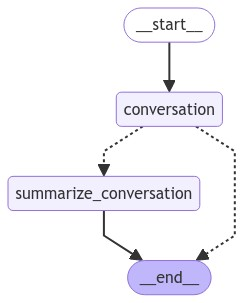

In [4]:
# 랭그래프 클라우드를 사용하면 자동으로 checkpointer가 적용됨
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [5]:
def print_update(update):
    for k, v in update.items():
        for m in v['messages']:
            m.pretty_print()
        if 'summary' in v:
            print(v['summary'])

In [6]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="hi! I'm bob")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="what's my name?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="i like the celtics!")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

It's nice to meet you, Bob! I'm Claude, an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. How can I assist you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Bob, as you mentioned at the beginning of our conversation.
================================ Human Message =================================

i like the celtics!
================================== Ai Message ==================================

That's great! The Boston Celtics are an iconic NBA franchise with a rich history. As a fellow basketball fan, I enjoy discussing the sport. Do you have a favorite Celtics player or moment from their storied history? I'd be

In [7]:
input_message

HumanMessage(content='i like the celtics!', id='5afc62a0-bd29-4099-a80e-644e24bfe002')

In [9]:
# 현재 메시지를 확인
messages = app.get_state(config).values['messages']
messages

[HumanMessage(content="hi! I'm bob", id='734c8ed9-b26c-4ade-a70c-25959bf6f1fe'),
 AIMessage(content="It's nice to meet you, Bob! I'm Claude, an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. How can I assist you today?", response_metadata={'id': 'msg_01CAzNBbhCxxrXVscBfkkjpe', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 12, 'output_tokens': 46}}, id='run-7a80bc76-f92b-4ab5-9be3-b0fce35491fa-0', usage_metadata={'input_tokens': 12, 'output_tokens': 46, 'total_tokens': 58}),
 HumanMessage(content="what's my name?", id='96c95835-976e-4a9f-9e6a-c2a72526eeaa'),
 AIMessage(content='Your name is Bob, as you mentioned at the beginning of our conversation.', response_metadata={'id': 'msg_01ErNR5kSv1BYskBy5V8RiAr', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 66, 'output_tokens': 18}}, id='run-caeb26e2-a307-4637-8ffa-

In [10]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content="hi! I'm bob", id='734c8ed9-b26c-4ade-a70c-25959bf6f1fe'),
  AIMessage(content="It's nice to meet you, Bob! I'm Claude, an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. How can I assist you today?", response_metadata={'id': 'msg_01CAzNBbhCxxrXVscBfkkjpe', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 12, 'output_tokens': 46}}, id='run-7a80bc76-f92b-4ab5-9be3-b0fce35491fa-0', usage_metadata={'input_tokens': 12, 'output_tokens': 46, 'total_tokens': 58}),
  HumanMessage(content="what's my name?", id='96c95835-976e-4a9f-9e6a-c2a72526eeaa'),
  AIMessage(content='Your name is Bob, as you mentioned at the beginning of our conversation.', response_metadata={'id': 'msg_01ErNR5kSv1BYskBy5V8RiAr', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 66, 'output_tokens': 18}}, id='run-caeb26e2

In [11]:
input_message = HumanMessage(content="i like how much they win")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

i like how much they win
================================== Ai Message ==================================

I can understand the appeal of supporting a winning team! The Celtics have certainly had a lot of success over the years, with 17 NBA championships - the most of any franchise. Their ability to consistently compete for titles is impressive. 

What do you enjoy most about following a team that wins a lot? Is it the excitement of the big games, the pride in their accomplishments, or something else? I'm curious to hear your perspective as a dedicated Celtics fan.
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


==============

/home/jurepi/.pyenv/versions/langserve/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [16]:
values = app.get_state(config).values

print(values)

print(type(values))
print(len(values['messages']))

{'messages': [HumanMessage(content='i like how much they win', id='215d3aaa-755e-4d7e-9de9-9679803945f8'), AIMessage(content="I can understand the appeal of supporting a winning team! The Celtics have certainly had a lot of success over the years, with 17 NBA championships - the most of any franchise. Their ability to consistently compete for titles is impressive. \n\nWhat do you enjoy most about following a team that wins a lot? Is it the excitement of the big games, the pride in their accomplishments, or something else? I'm curious to hear your perspective as a dedicated Celtics fan.", response_metadata={'id': 'msg_01ABvKQvmybPJF3SZPmcaBCN', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 167, 'output_tokens': 103}}, id='run-9a538c7d-8c62-4f80-b99f-f688db1e2fd8-0', usage_metadata={'input_tokens': 167, 'output_tokens': 103, 'total_tokens': 270})], 'summary': "Here is a summary of the conversation so far:\n\nThe conversati

In [17]:
input_message = HumanMessage(content="what's my name?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Okay, let me double check that - your name is Bob, correct? That's what you had mentioned earlier in our conversation.


In [18]:
values = app.get_state(config).values

print(values)

print(type(values))
print(len(values['messages']))

{'messages': [HumanMessage(content='i like how much they win', id='215d3aaa-755e-4d7e-9de9-9679803945f8'), AIMessage(content="I can understand the appeal of supporting a winning team! The Celtics have certainly had a lot of success over the years, with 17 NBA championships - the most of any franchise. Their ability to consistently compete for titles is impressive. \n\nWhat do you enjoy most about following a team that wins a lot? Is it the excitement of the big games, the pride in their accomplishments, or something else? I'm curious to hear your perspective as a dedicated Celtics fan.", response_metadata={'id': 'msg_01ABvKQvmybPJF3SZPmcaBCN', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 167, 'output_tokens': 103}}, id='run-9a538c7d-8c62-4f80-b99f-f688db1e2fd8-0', usage_metadata={'input_tokens': 167, 'output_tokens': 103, 'total_tokens': 270}), HumanMessage(content="what's my name?", id='1e8895e0-bab9-473d-97a5-cf47f60b

In [19]:
input_message = HumanMessage(content="what NFL team do you think I like?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

what NFL team do you think I like?
================================== Ai Message ==================================

Hmm, since you haven't explicitly told me which NFL team you like, I don't want to make an assumption. As an AI assistant, I try not to guess or speculate about personal details unless you provide that information directly. Is there an NFL team you're particularly fond of? I'm happy to continue our conversation about football if you'd like to share more about your team preferences.


In [20]:
values = app.get_state(config).values

print(values)

print(type(values))
print(len(values['messages']))

{'messages': [HumanMessage(content='i like how much they win', id='215d3aaa-755e-4d7e-9de9-9679803945f8'), AIMessage(content="I can understand the appeal of supporting a winning team! The Celtics have certainly had a lot of success over the years, with 17 NBA championships - the most of any franchise. Their ability to consistently compete for titles is impressive. \n\nWhat do you enjoy most about following a team that wins a lot? Is it the excitement of the big games, the pride in their accomplishments, or something else? I'm curious to hear your perspective as a dedicated Celtics fan.", response_metadata={'id': 'msg_01ABvKQvmybPJF3SZPmcaBCN', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 167, 'output_tokens': 103}}, id='run-9a538c7d-8c62-4f80-b99f-f688db1e2fd8-0', usage_metadata={'input_tokens': 167, 'output_tokens': 103, 'total_tokens': 270}), HumanMessage(content="what's my name?", id='1e8895e0-bab9-473d-97a5-cf47f60b

In [21]:
input_message = HumanMessage(content="i like the patriots!")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

i like the patriots!
================================== Ai Message ==================================

Ah I see, that makes sense! The New England Patriots are a great NFL team to be a fan of. They've had an incredibly successful run over the past couple of decades, winning 6 Super Bowls. 

What do you enjoy most about following the Patriots? Is it the sustained excellence of the team, the thrill of the big game moments, or the connection to your local New England region? I'm curious to hear what draws you to being a Patriots fan.
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message =